In [1]:
import torch
import random 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading dataset
words = open(r"data\names.txt").read().splitlines()
print(f"Number of words: {len(words)}")
print(f"first 5 words: {words[:5]}")

Number of words: 55272
first 5 words: ['parish', 'manhi', 'akshaykeerti', 'suran', 'tomali']


In [5]:
# creating a look up table (dictionary to map int to characters and vice versa)
chars = sorted(list(set(''.join(words))))
ch_to_id = {ch:i+1 for i, ch in enumerate(chars)}
ch_to_id['.'] = 0 # special char to mark ending and starting of a word
vocab_size = len(ch_to_id)
id_to_ch = {i:ch for ch, i in ch_to_id.items()}
print(f"Charecters to id: {ch_to_id}")
print(f"Id to charecters: {id_to_ch}")
print(f"Vocab size: {vocab_size}")

Charecters to id: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Id to charecters: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


In [4]:
# building our datasets: training split(80%), dev/validation split(10%) and test split(10%)

block_size = 3 # context length: how many charecters to consider to predict the next charecter
def buid_dataset(words, str):
    
    X, Y = [], [] # X: context, Y: target
    
    for word in words:
        context = [0] * block_size
        for ch in word + ".": # adding a special char to mark the end of a word
            current_idx = ch_to_id[ch]
            X.append(context)
            Y.append(current_idx)
            context = context[1:] + [current_idx] # sliding the context window
            
    # converting the dataset to tensors        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"\nX_{str} shape: {X.shape}")
    print(f"Y_{str} shape: {Y.shape}")
    return X, Y

random.shuffle(words)
lim1 = int(len(words) * 0.8)
lim2 = int(len(words) * 0.9)

X_train, Y_train = buid_dataset(words[:lim1], "train")
X_dev, Y_dev = buid_dataset(words[lim1:lim2], "dev")
X_test, Y_test = buid_dataset(words[lim2:], "test")


X_train shape: torch.Size([401463, 3])
Y_train shape: torch.Size([401463])

X_dev shape: torch.Size([50269, 3])
Y_dev shape: torch.Size([50269])

X_test shape: torch.Size([50235, 3])
Y_test shape: torch.Size([50235])


In [172]:
# defining mlp architecture like elmo
n_embedding = 10 # char embedding vector dimensionality
n_hidden = 200 # no of neurons in hidden layer
g = torch.Generator().manual_seed(42) # for reproducibility

E = torch.randn(vocab_size, n_embedding, generator=g) # embedding lookup table
# hidden layer
W1 = torch.randn(n_embedding * block_size, n_hidden, generator=g) * (5/3)/((n_embedding * block_size)**0.5) # kaiming initialization to tackle exploding gradients and reduce initial loss
b1 = torch.randn(n_hidden, generator=g) * 0.01 # to tackle vanishing gradients
# output layer
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # scaling down the weights to reduce initial loss and prevent exploding gradients
b2 = torch.randn(vocab_size, generator=g) * 0 

params = [E, W1, b1, W2, b2]
for p in params:
    p.requires_grad_()
print(f"Number of parameters: {sum(p.nelement() for p in params)}")

# stats to track
steps = []
steps_loss = []

Number of parameters: 11897


In [173]:
# optimization
epochs = 200000
batch_size = 32

for epoch in range(epochs):
    # constructing mini batches
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    mini_X, mini_Y = X_train[idx], Y_train[idx]
    
    # forward pass
    embeddings = E[mini_X] # embed cahr in vectors
    embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors
    pre_hidd_out = (embcat @ W1 + b1) # hidden layer output without activation
    hidd_out = torch.tanh(pre_hidd_out)
    logits = (hidd_out @ W2 + b2) # output layer
    loss = F.cross_entropy(logits, mini_Y) # loss
        
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # params update
    lr = 0.1 if epoch < 100000 else 0.001 # learning rate decay
    for p in params:
        p.data -= lr * p.grad
    
    # stats
    if epoch % 10000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f}")
    steps.append(epoch+1)
    steps_loss.append(loss.log10().item())
print(f"Final loss: {loss}")

Epoch: 0 | Loss: 3.2670
Epoch: 10000 | Loss: 1.8980
Epoch: 20000 | Loss: 1.9879
Epoch: 30000 | Loss: 1.8499
Epoch: 40000 | Loss: 1.8988
Epoch: 50000 | Loss: 1.6608
Epoch: 60000 | Loss: 1.8922
Epoch: 70000 | Loss: 2.1343
Epoch: 80000 | Loss: 2.2953
Epoch: 90000 | Loss: 2.1002
Epoch: 100000 | Loss: 2.1962
Epoch: 110000 | Loss: 2.1836
Epoch: 120000 | Loss: 2.0534
Epoch: 130000 | Loss: 1.7373
Epoch: 140000 | Loss: 1.7412
Epoch: 150000 | Loss: 1.6751
Epoch: 160000 | Loss: 2.0311
Epoch: 170000 | Loss: 1.6582
Epoch: 180000 | Loss: 2.2614
Epoch: 190000 | Loss: 1.5831
Final loss: 1.9253299236297607


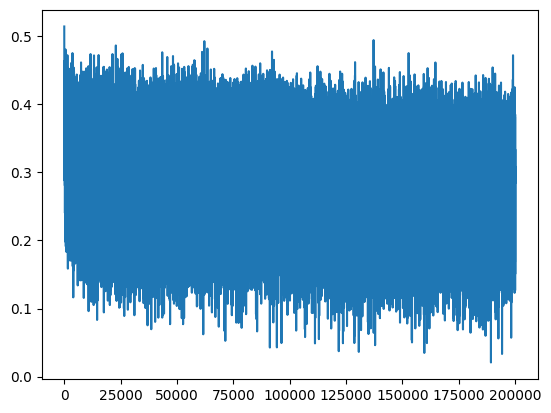

In [174]:
# plotting loss
plt.plot(steps, steps_loss)

In [175]:
# training and validation losses
@torch.no_grad() # decorator to disable gradient calculation

def split_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test)
    }[split]
    
    embeddings = E[x]
    embcat = embeddings.view(embeddings.shape[0], -1)
    pre_hidd_out = embcat @ W1 + b1
    hidd_out = torch.tanh(pre_hidd_out)
    logits = hidd_out @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    return loss.item()

print(f"Train loss: {split_loss('train'):.4f}")
print(f"Val loss: {split_loss('val'):.4f}")

Train loss: 1.8941
Val loss: 1.9086


In [176]:
# sampling from the model
g = torch.Generator()
predicted_names = []
block_size = 3

for _ in range(20):
    name = ""
    context = [0] * block_size
    while True:
        embeddings = E[torch.tensor([context])] # (1, 3, 10)
        hidd_out = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = hidd_out @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sampling from the distribution
        next_char = torch.multinomial(probs, 1, generator=g).item()
        # shifting the context window
        context = context[1:] + [next_char]
        
        if next_char != 0:
            name += id_to_ch[next_char]
        else:
            predicted_names.append(name)
            break
predicted_names

['chita',
 'priya',
 'hynthea',
 'tha',
 'aayenthikraki',
 'amaleya',
 'shaniraanima',
 'maabhi',
 'hian',
 'thra',
 'nivaanibhagavini',
 'mushen',
 'aarsha',
 'mohita',
 'indra',
 'bha',
 'prashana',
 'gundir',
 'prathushaguvilojanika',
 'raven']